# Data Validation

In the previous notebook, two pins were saved:

- City of Chicago - Business License Data (RAW): `chicago-business-license-data`
- ity of Chicago - Food Inspection Data (RAW): `chicago-food-inspection-data`

## Setup

In [1]:
import os
import requests

import ibis
import pins
import pandas as pd
import numpy as np
import pandera as pa
from sqlalchemy import create_engine, text

In [2]:
pd.options.display.max_columns = 999

In [3]:
# Database details
db_user = "posit"
db_password = os.environ["CONF23_DB_PASSWORD"]
db_host = os.environ["CONF23_DB_HOST"]
db_port = 5432
db_database = "conf23_python"

# Set up sqlalchemy for writing data
engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}/{db_database}")

# Set up ibis for reading data
con = ibis.postgres.connect(
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port,
    database=db_database
)

Set dyanmic variables. To ensure that we do not have overload the database or the server, only the instructors scripts will run on the full data set.

In [4]:
connect_username = requests.get(
    f"{os.environ['CONNECT_SERVER']}/__api__/v1/user",
    headers={"Authorization": f"Key {os.environ['CONNECT_API_KEY']}"}
).json()["username"]

connect_username

'sam.edwardes'

In [5]:
if connect_username == "sam.edwardes":
    max_rows = 99_999_999
else:
    max_rows = 10_000

max_rows

99999999

## Load raw data

Use `ibis` to read the data from Postgres.

In [6]:
business_license_raw = con.table("business_license_raw").limit(max_rows).to_pandas()

In [7]:
food_inspection_raw = con.table("food_inspection_raw").limit(max_rows).to_pandas()

## Data Exploration

Does each license only one row in the table?

In [8]:
business_license_raw["license_id"].value_counts().sort_values(ascending=False)

1119073    1
44721      1
1000971    1
1042446    1
1042910    1
          ..
1981963    1
1981554    1
1981967    1
2066649    1
2066650    1
Name: license_id, Length: 34928, dtype: int64

Does all the data relate to Chicago?

In [9]:
business_license_raw["city"].value_counts().sort_values(ascending=False)

CHICAGO              34777
MAYWOOD                 13
ELK GROVE VILLAGE        7
INGLEWOOD                7
SCHAUMBURG               6
                     ...  
SCHAMBURG                1
BANNOCKBURN              1
MERRILLVILLE             1
GLENCOE                  1
CAROL STREAM             1
Name: city, Length: 81, dtype: int64

In [10]:
business_license_raw["state"].value_counts().sort_values(ascending=False)

IL    34913
CA       10
NY        2
IN        2
WI        1
Name: state, dtype: int64

##### Food inspection data 

What are the different risk levels?

<Axes: >

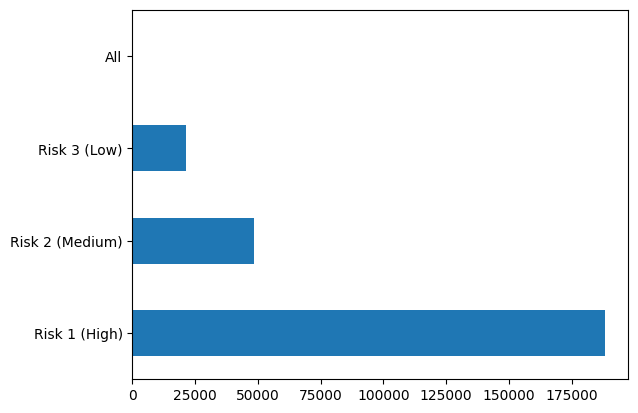

In [11]:
food_inspection_raw["risk"].value_counts().plot(kind="barh")

What are the most common violations?

In [12]:
food_inspection_raw["violations"].value_counts().sort_values(ascending=False)

32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: VIOLATION STILL PENDING                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

What are the most common outcomes?

<Axes: >

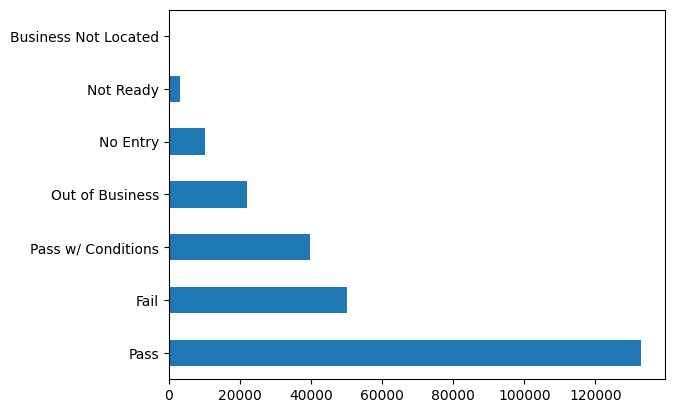

In [13]:
food_inspection_raw["results"].value_counts().plot(kind="barh")

What are the most common facility types?

In [14]:
food_inspection_raw["facility_type"].value_counts().sort_values(ascending=False).head(25)

Restaurant                         173206
Grocery Store                       32389
School                              16222
Children's Services Facility         5250
Bakery                               3738
Daycare Above and Under 2 Years      3407
Daycare (2 - 6 Years)                3083
Long Term Care                       1863
Catering                             1594
Liquor                               1106
Mobile Food Dispenser                 923
Mobile Food Preparer                  911
Hospital                              764
Golden Diner                          723
Daycare Combo 1586                    691
Wholesale                             552
TAVERN                                389
Shared Kitchen User (Long Term)       314
Daycare (Under 2 Years)               312
Special Event                         287
Shared Kitchen                        219
GAS STATION                           198
BANQUET HALL                          183
Mobile Prepared Food Vendor       

## Data set (1): Business License Data

<https://data.cityofchicago.org/Community-Economic-Development/Business-Licenses/r5kz-chrr>

In [15]:
business_license_raw

,id,license_id,account_number,site_number,legal_name,doing_business_as_name,address,city,state,zip_code,ward,precinct,ward_precinct,police_district,license_code,license_description,business_activity_id,business_activity,license_number,application_type,application_created_date,application_requirements_complete,payment_date,conditional_approval,license_start_date,expiration_date,license_approved_for_issuance,date_issued,license_status,license_status_change_date,ssa,latitude,longitude,location
0,1000971-20020913,1000971,6748,3,BOULEVARD CARE CENTER INC,Kensington Place Nursing and Rehabilitation Ce...,3405 S MICHIGAN AVE,CHICAGO,IL,60616,3,53,3-53,2,1005,Long-Term Care Facility,None,None,1000971,ISSUE,2000-06-29T00:00:00.000,2002-07-23T00:00:00.000,2002-07-23T00:00:00.000,N,2002-09-13T00:00:00.000,2003-08-15T00:00:00.000,2002-09-12T00:00:00.000,2002-09-13T00:00:00.000,AAI,None,None,41.83267813,-87.623147607,"\n, \n(41.83267813012173, -87.62314760698986)"
1,1042446-20020322,1042446,201709,1,"D & G DOWNTOWN, INC.",COSTAS,332-340 S HALSTED ST,CHICAGO,IL,60661,34,58,34-58,12,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1042446,ISSUE,2000-07-10T00:00:00.000,2000-07-24T00:00:00.000,2000-07-26T00:00:00.000,N,2002-03-22T00:00:00.000,2002-08-15T00:00:00.000,2002-03-22T00:00:00.000,2002-03-22T00:00:00.000,AAI,None,16,41.876931404,-87.647356562,"\n, \n(41.87693140416427, -87.64735656177236)"
2,1042910-20020108,1042910,202009,1,"VINCE'S PIZZA, INC",VINCE'S PIZZA,6217 W 63RD ST,CHICAGO,IL,60638,13,39,13-39,8,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1042910,ISSUE,2000-07-17T00:00:00.000,2001-09-27T00:00:00.000,2001-10-11T00:00:00.000,N,2002-01-08T00:00:00.000,2003-02-15T00:00:00.000,2002-01-08T00:00:00.000,2002-01-08T00:00:00.000,AAI,None,None,41.777645377,-87.777065958,"\n, \n(41.77764537687134, -87.77706595836504)"
3,1043697-20020708,1043697,202535,1,"MONGOLIAN OPERATING COMPANY, LLC.",BD'S MONGOLIAN BARBEQUE OF WRIGLEYVILLE,3330 N CLARK ST,CHICAGO,IL,60657,44,20,44-20,19,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1043697,ISSUE,2000-07-26T00:00:00.000,2002-04-30T00:00:00.000,2002-05-01T00:00:00.000,N,2002-07-08T00:00:00.000,2003-02-15T00:00:00.000,2002-07-02T00:00:00.000,2002-07-08T00:00:00.000,AAI,None,17,41.94248613,-87.652896611,"\n, \n(41.942486129981106, -87.65289661051825)"
4,1044746-20020516,1044746,203231,1,"EDWARD & ANDREW, INC.",SUSHI O SUSHI,346 W ARMITAGE AVE LOWER LEVEL,CHICAGO,IL,60614,43,17,43-17,18,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1044746,ISSUE,2000-08-08T00:00:00.000,2002-04-08T00:00:00.000,2002-04-10T00:00:00.000,N,2002-05-16T00:00:00.000,2002-11-15T00:00:00.000,2002-05-15T00:00:00.000,2002-05-16T00:00:00.000,AAI,None,None,41.918440433,-87.638258286,"\n, \n(41.91844043280386, -87.63825828564545)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34923,8136-20090916,1981781,25799,1,ERNIE'S LOCAL AUTO INC,ERNIE'S LOCAL AUTOMOTIVES INC,6424 W HIGGINS AVE,CHICAGO,IL,60656,41,9,41-9,16,1569,Motor Vehicle Repair : Engine Only (Class II),None,None,8136,RENEW,None,2009-07-15T00:00:00.000,2009-08-21T00:00:00.000,N,2009-09-16T00:00:00.000,2011-09-15T00:00:00.000,2009-11-18T00:00:00.000,2009-11-18T00:00:00.000,AAI,None,None,41.976730788,-87.78886624,"\n, \n(41.976730788067556, -87.78886624026508)"
34924,83368-20110116,2066699,89020,17,"FEDEX OFFICE AND PRINT SERVICES, INC.","FEDEX OFFICE AND PRINT SVCS, INC.",1242 S CANAL ST 6,CHICAGO,IL,60607,28,28,28-28,1,1014,Retail Computing Center,None,None,83368,RENEW,None,2010-11-15T00:00:00.000,2010-12-29T00:00:00.000,N,2011-01-16T00:00:00.000,2013-01-15T00:00:00.000,2010-12-29T00:00:00.000,2011-01-11T00:00:00.000,AAC,2012-06-20T00:00:00.000,None,41.866069633,-87.63935476,"\n, \n(41.866069632888056, -87.63935475981337)"
34925,9201-20000516,42182,86581,2,"LELAND INN, INC.",LELAND INN INC,4663 N ROC

**Data tidying**

Apply some basic tidying steps to the data.

In [16]:
business_license_tidy = business_license_raw.copy()
business_license_tidy

,id,license_id,account_number,site_number,legal_name,doing_business_as_name,address,city,state,zip_code,ward,precinct,ward_precinct,police_district,license_code,license_description,business_activity_id,business_activity,license_number,application_type,application_created_date,application_requirements_complete,payment_date,conditional_approval,license_start_date,expiration_date,license_approved_for_issuance,date_issued,license_status,license_status_change_date,ssa,latitude,longitude,location
0,1000971-20020913,1000971,6748,3,BOULEVARD CARE CENTER INC,Kensington Place Nursing and Rehabilitation Ce...,3405 S MICHIGAN AVE,CHICAGO,IL,60616,3,53,3-53,2,1005,Long-Term Care Facility,None,None,1000971,ISSUE,2000-06-29T00:00:00.000,2002-07-23T00:00:00.000,2002-07-23T00:00:00.000,N,2002-09-13T00:00:00.000,2003-08-15T00:00:00.000,2002-09-12T00:00:00.000,2002-09-13T00:00:00.000,AAI,None,None,41.83267813,-87.623147607,"\n, \n(41.83267813012173, -87.62314760698986)"
1,1042446-20020322,1042446,201709,1,"D & G DOWNTOWN, INC.",COSTAS,332-340 S HALSTED ST,CHICAGO,IL,60661,34,58,34-58,12,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1042446,ISSUE,2000-07-10T00:00:00.000,2000-07-24T00:00:00.000,2000-07-26T00:00:00.000,N,2002-03-22T00:00:00.000,2002-08-15T00:00:00.000,2002-03-22T00:00:00.000,2002-03-22T00:00:00.000,AAI,None,16,41.876931404,-87.647356562,"\n, \n(41.87693140416427, -87.64735656177236)"
2,1042910-20020108,1042910,202009,1,"VINCE'S PIZZA, INC",VINCE'S PIZZA,6217 W 63RD ST,CHICAGO,IL,60638,13,39,13-39,8,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1042910,ISSUE,2000-07-17T00:00:00.000,2001-09-27T00:00:00.000,2001-10-11T00:00:00.000,N,2002-01-08T00:00:00.000,2003-02-15T00:00:00.000,2002-01-08T00:00:00.000,2002-01-08T00:00:00.000,AAI,None,None,41.777645377,-87.777065958,"\n, \n(41.77764537687134, -87.77706595836504)"
3,1043697-20020708,1043697,202535,1,"MONGOLIAN OPERATING COMPANY, LLC.",BD'S MONGOLIAN BARBEQUE OF WRIGLEYVILLE,3330 N CLARK ST,CHICAGO,IL,60657,44,20,44-20,19,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1043697,ISSUE,2000-07-26T00:00:00.000,2002-04-30T00:00:00.000,2002-05-01T00:00:00.000,N,2002-07-08T00:00:00.000,2003-02-15T00:00:00.000,2002-07-02T00:00:00.000,2002-07-08T00:00:00.000,AAI,None,17,41.94248613,-87.652896611,"\n, \n(41.942486129981106, -87.65289661051825)"
4,1044746-20020516,1044746,203231,1,"EDWARD & ANDREW, INC.",SUSHI O SUSHI,346 W ARMITAGE AVE LOWER LEVEL,CHICAGO,IL,60614,43,17,43-17,18,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1044746,ISSUE,2000-08-08T00:00:00.000,2002-04-08T00:00:00.000,2002-04-10T00:00:00.000,N,2002-05-16T00:00:00.000,2002-11-15T00:00:00.000,2002-05-15T00:00:00.000,2002-05-16T00:00:00.000,AAI,None,None,41.918440433,-87.638258286,"\n, \n(41.91844043280386, -87.63825828564545)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34923,8136-20090916,1981781,25799,1,ERNIE'S LOCAL AUTO INC,ERNIE'S LOCAL AUTOMOTIVES INC,6424 W HIGGINS AVE,CHICAGO,IL,60656,41,9,41-9,16,1569,Motor Vehicle Repair : Engine Only (Class II),None,None,8136,RENEW,None,2009-07-15T00:00:00.000,2009-08-21T00:00:00.000,N,2009-09-16T00:00:00.000,2011-09-15T00:00:00.000,2009-11-18T00:00:00.000,2009-11-18T00:00:00.000,AAI,None,None,41.976730788,-87.78886624,"\n, \n(41.976730788067556, -87.78886624026508)"
34924,83368-20110116,2066699,89020,17,"FEDEX OFFICE AND PRINT SERVICES, INC.","FEDEX OFFICE AND PRINT SVCS, INC.",1242 S CANAL ST 6,CHICAGO,IL,60607,28,28,28-28,1,1014,Retail Computing Center,None,None,83368,RENEW,None,2010-11-15T00:00:00.000,2010-12-29T00:00:00.000,N,2011-01-16T00:00:00.000,2013-01-15T00:00:00.000,2010-12-29T00:00:00.000,2011-01-11T00:00:00.000,AAC,2012-06-20T00:00:00.000,None,41.866069633,-87.63935476,"\n, \n(41.866069632888056, -87.63935475981337)"
34925,9201-20000516,42182,86581,2,"LELAND INN, INC.",LELAND INN INC,4663 N ROC

In [17]:
# Filter to only keep state of IL
business_license_tidy = business_license_tidy.assign(
    state=business_license_tidy["state"].str.upper()
)

business_license_tidy = business_license_tidy.loc[business_license_tidy["state"] == "IL", :]

In [18]:
# Filter to only keep city of Chicago
business_license_tidy = business_license_tidy.assign(
    city=business_license_tidy["city"].str.upper()
)

business_license_tidy = business_license_tidy.loc[business_license_tidy["city"] == "CHICAGO", :]

In [19]:
# Convert conditional approval to a boolean value.
business_license_tidy = business_license_tidy.assign(
    conditional_approval=business_license_tidy["conditional_approval"].str.upper()
)

business_license_tidy = business_license_tidy.assign(
    conditional_approval=business_license_tidy["conditional_approval"].apply(lambda x: x == "Y")
)

In [20]:
# Drop the "location" column, the same data is already stored in the "latitude"
# and "longitude" columns.
business_license_tidy = business_license_tidy.drop(columns=["location"])

In [21]:
# Reset the index
business_license_tidy = business_license_tidy.reset_index(drop=True)

**Data validation**

Use pandera to validate the data and convert each column to the correct type.

In [22]:
business_license_schema = pa.DataFrameSchema(
    columns={
        "id": pa.Column(str, coerce=True),
        "license_id": pa.Column(str, coerce=True, unique=True), # Primary Key
        "account_number": pa.Column(str, coerce=True),
        "site_number": pa.Column(str, coerce=True),
        "legal_name": pa.Column(str, coerce=True),
        "doing_business_as_name": pa.Column(str, coerce=True, nullable=True),
        "address": pa.Column(str, coerce=True),
        "city": pa.Column(str, coerce=True, nullable=True, checks=[
            pa.Check.eq("CHICAGO")
        ]),
        "state": pa.Column(str, coerce=True, nullable=True, checks=[
            pa.Check.eq("IL")
        ]),
        "zip_code": pa.Column(str, coerce=True, nullable=True, checks=[
            pa.Check(lambda x: x.str.match(r'^\d{5}$').all())
        ]),
        "ward": pa.Column(str, coerce=True, nullable=True),
        "precinct": pa.Column(str, coerce=True, nullable=True),
        "ward_precinct": pa.Column(str, coerce=True, nullable=True),
        "police_district": pa.Column(pa.Category, coerce=True, nullable=True),
        "license_code": pa.Column(pa.Category, coerce=True),
        "license_description": pa.Column(str, coerce=True),
        "business_activity_id": pa.Column(str, coerce=True, nullable=True),
        "business_activity": pa.Column(pa.Category, coerce=True, nullable=True),
        "license_number": pa.Column(str, coerce=True),
        "application_type": pa.Column(pa.Category, coerce=True),
        "application_created_date": pa.Column(str, coerce=True, nullable=True),
        "application_requirements_complete": pa.Column(pa.DateTime, coerce=True, nullable=True),
        "payment_date": pa.Column(pa.DateTime, coerce=True, nullable=True),
        "conditional_approval": pa.Column(bool, coerce=True),
        "license_start_date": pa.Column(pa.DateTime, coerce=True, nullable=True),
        "expiration_date": pa.Column(pa.DateTime, coerce=True, nullable=True),
        "license_approved_for_issuance": pa.Column(pa.DateTime, coerce=True, nullable=True),
        "date_issued": pa.Column(pa.DateTime, coerce=True),
        "license_status": pa.Column(pa.Category, coerce=True),
        "license_status_change_date": pa.Column(pa.DateTime, coerce=True, nullable=True),
        "ssa": pa.Column(str, coerce=True, nullable=True),
        "latitude": pa.Column(pa.Float, coerce=True, nullable=True, checks=[
            pa.Check.between(38, 44)
        ]),
        "longitude": pa.Column(pa.Float, coerce=True, nullable=True, checks=[
            pa.Check.between(-89, -84)
        ]),
    }
)



business_license_validated = business_license_schema.validate(business_license_tidy)
business_license_validated

,id,license_id,account_number,site_number,legal_name,doing_business_as_name,address,city,state,zip_code,ward,precinct,ward_precinct,police_district,license_code,license_description,business_activity_id,business_activity,license_number,application_type,application_created_date,application_requirements_complete,payment_date,conditional_approval,license_start_date,expiration_date,license_approved_for_issuance,date_issued,license_status,license_status_change_date,ssa,latitude,longitude
0,1000971-20020913,1000971,6748,3,BOULEVARD CARE CENTER INC,Kensington Place Nursing and Rehabilitation Ce...,3405 S MICHIGAN AVE,CHICAGO,IL,60616,3,53,3-53,2,1005,Long-Term Care Facility,None,NaN,1000971,ISSUE,2000-06-29T00:00:00.000,2002-07-23,2002-07-23,False,2002-09-13,2003-08-15,2002-09-12,2002-09-13,AAI,NaT,None,41.832678,-87.623148
1,1042446-20020322,1042446,201709,1,"D & G DOWNTOWN, INC.",COSTAS,332-340 S HALSTED ST,CHICAGO,IL,60661,34,58,34-58,12,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1042446,ISSUE,2000-07-10T00:00:00.000,2000-07-24,2000-07-26,False,2002-03-22,2002-08-15,2002-03-22,2002-03-22,AAI,NaT,16,41.876931,-87.647357
2,1042910-20020108,1042910,202009,1,"VINCE'S PIZZA, INC",VINCE'S PIZZA,6217 W 63RD ST,CHICAGO,IL,60638,13,39,13-39,8,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1042910,ISSUE,2000-07-17T00:00:00.000,2001-09-27,2001-10-11,False,2002-01-08,2003-02-15,2002-01-08,2002-01-08,AAI,NaT,None,41.777645,-87.777066
3,1043697-20020708,1043697,202535,1,"MONGOLIAN OPERATING COMPANY, LLC.",BD'S MONGOLIAN BARBEQUE OF WRIGLEYVILLE,3330 N CLARK ST,CHICAGO,IL,60657,44,20,44-20,19,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1043697,ISSUE,2000-07-26T00:00:00.000,2002-04-30,2002-05-01,False,2002-07-08,2003-02-15,2002-07-02,2002-07-08,AAI,NaT,17,41.942486,-87.652897
4,1044746-20020516,1044746,203231,1,"EDWARD & ANDREW, INC.",SUSHI O SUSHI,346 W ARMITAGE AVE LOWER LEVEL,CHICAGO,IL,60614,43,17,43-17,18,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1044746,ISSUE,2000-08-08T00:00:00.000,2002-04-08,2002-04-10,False,2002-05-16,2002-11-15,2002-05-15,2002-05-16,AAI,NaT,None,41.918440,-87.638258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34771,8136-20090916,1981781,25799,1,ERNIE'S LOCAL AUTO INC,ERNIE'S LOCAL AUTOMOTIVES INC,6424 W HIGGINS AVE,CHICAGO,IL,60656,41,9,41-9,16,1569,Motor Vehicle Repair : Engine Only (Class II),None,NaN,8136,RENEW,None,2009-07-15,2009-08-21,False,2009-09-16,2011-09-15,2009-11-18,2009-11-18,AAI,NaT,None,41.976731,-87.788866
34772,83368-20110116,2066699,89020,17,"FEDEX OFFICE AND PRINT SERVICES, INC.","FEDEX OFFICE AND PRINT SVCS, INC.",1242 S CANAL ST 6,CHICAGO,IL,60607,28,28,28-28,1,1014,Retail Computing Center,None,NaN,83368,RENEW,None,2010-11-15,2010-12-29,False,2011-01-16,2013-01-15,2010-12-29,2011-01-11,AAC,2012-06-20,None,41.866070,-87.639355
34773,9201-20000516,42182,86581,2,"LELAND INN, INC.",LELAND INN INC,4663 N ROCKWELL ST 1ST,CHICAGO,IL,60625,47,40,47-40,19,1470,Tavern,None,NaN,9201,RENEW,None,2000-06-16,NaT,False,2000-05-16,2000-11-13,2003-01-06,2003-01-08,AAC,2003-04-02,None,41.966693,-87.693600
34774,9494-20090916,1981795,26124,1,WARING INDUSTRIAL,WARING INDUSTRIAL TOOL,4524 N LINCOLN AVE,CHICAGO,IL,60625,47,42,47-42,19,1010,Limited Business License,None,NaN,9494,RENEW,None,2009-07-15,2009-08-19,False,2009-09-16,2011-09-15,2009-08-19,2009-08-20,AAI,NaT,21,41.963808,-87.685569


Insert the data into postgresql.

In [23]:
# determine the table name
if connect_username == "sam.edwardes":
    table_name_prefix = ""
else:
    table_name_prefix = re.sub('[^0-9a-zA-Z]+', '_', "sam-edwardes") + "_"

table_name = f"{table_name_prefix}business_license_validated"

table_name

'business_license_validated'

In [24]:
# Insert the data into postgres. Inserting large amounts of data can be slow, so
# iterate over 10,000 rows at a time.

n_rows = business_license_validated.shape[0]
step_size = 10_000

for i in range(0, n_rows, step_size):
    index_start = i
    index_end = min(n_rows, i + step_size - 1)
    
    if i == 0:
        if_exists = "replace"
    else:
        if_exists = "append"

    print(f"Inserting rows: {index_start:,} - {index_end:,}")
    
    business_license_validated \
        .loc[index_start:index_end, :] \
        .to_sql(table_name, engine, if_exists=if_exists, index=False)

Inserting rows: 0 - 9,999
Inserting rows: 10,000 - 19,999
Inserting rows: 20,000 - 29,999
Inserting rows: 30,000 - 34,776


In [25]:
# Confirm number of rows
with engine.begin() as conn:
    query = text(f"SELECT COUNT(*) FROM {table_name}")
    number_of_rows = pd.read_sql_query(query, conn)

print(number_of_rows)

   count
0  34776


## Data set (2): Food inspections

<https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5>

In [26]:
food_inspection_raw

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
0,52234,Cafe 608,Cafe 608,2013328,Restaurant,Risk 1 (High),608 W BARRY AVE,CHICAGO,IL,60657,2010-01-04T00:00:00.000,License Re-Inspection,Pass,None,41.938006880423615,-87.6447545707008,"(41.938006880423615, -87.6447545707008)"
1,70269,mr.daniel's,mr.daniel's,1899292,Restaurant,Risk 1 (High),5645 W BELMONT AVE,CHICAGO,IL,60634,2010-01-04T00:00:00.000,License Re-Inspection,Pass,None,41.93844282365204,-87.76831838068422,"(41.93844282365204, -87.76831838068422)"
2,67733,WOLCOTT'S,TROQUET,1992040,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04T00:00:00.000,License Re-Inspection,Pass,None,41.961605669949854,-87.67596676683779,"(41.961605669949854, -87.67596676683779)"
3,67732,WOLCOTT'S,TROQUET,1992039,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,CHICAGO,IL,60613,2010-01-04T00:00:00.000,License Re-Inspection,Pass,None,41.961605669949854,-87.67596676683779,"(41.961605669949854, -87.67596676683779)"
4,104236,TEMPO CAFE,TEMPO CAFE,80916,Restaurant,Risk 1 (High),6 E CHESTNUT ST,CHICAGO,IL,60611,2010-01-04T00:00:00.000,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.89843137207629,-87.6280091630558,"(41.89843137207629, -87.6280091630558)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258048,2579953,"GIFTED CHILDREN ACADEMY, INC.",GIFTED CHILDREN ACADEMY,2216124,Daycare Combo 1586,Risk 1 (High),1520-1524 W HOWARD ST,CHICAGO,IL,60626,2023-08-11T00:00:00.000,License,Pass,None,42.0194729200876,-87.66917452134184,"(42.0194729200876, -87.66917452134184)"
258049,2579943,EGGSPERIENCE,EGGSPERIENCE,2583306,Restaurant,Risk 1 (High),3231-3233 N BROADWAY,CHICAGO,IL,60657,2023-08-11T00:00:00.000,Canvass Re-Inspection,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.941021951821966,-87.64428253705525,"(41.941021951821966, -87.64428253705525)"
258050,2579939,LA FIESTA BAKERY,LA FIESTA BAKERY/TAQUERIA,1488177,Restaurant,Risk 1 (High),6424 S PULASKI RD,CHICAGO,IL,60629,2023-08-11T00:00:00.000,Canvass,Pass,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.77607320206961,-87.72284124538348,"(41.77607320206961, -87.72284124538348)"
258051,2579946,GROTA RESTAURANT,GROTA RESTAURANT,6753,Restaurant,Risk 1 (High),3108-3112 N CENTRAL AVE,CHICAGO,IL,60634,2023-08-11T00:00:00.000,Canvass Re-Inspection,Pass,None,41.93706710815131,-87.76659233846347,"(41.93706710815131, -87.76659233846347)"


**Data cleaning**

Apply some basic cleaning steps to the data.

In [27]:
food_inspection_tidy = food_inspection_raw.copy()

In [28]:
# Filter to only keep state of IL
food_inspection_tidy = food_inspection_tidy.assign(
    state=food_inspection_tidy["state"].str.upper()
)

food_inspection_tidy = food_inspection_tidy.loc[food_inspection_tidy["state"] == "IL", :]

In [29]:
# Filter to only keep city of Chicago
food_inspection_tidy = food_inspection_tidy.assign(
    city=food_inspection_tidy["city"].str.upper()
)

food_inspection_tidy = food_inspection_tidy.loc[food_inspection_tidy["city"] == "CHICAGO", :]

In [30]:
# Drop columns that also exist in the business license data.
food_inspection_tidy = food_inspection_tidy.drop(columns=["address", "city", "state", "latitude", "longitude", "location"])

In [31]:
# Convert categorical columns to be all upper case for consistency
food_inspection_tidy = food_inspection_tidy.assign(
    dba_name=lambda x: x["dba_name"].str.upper(),
    aka_name=lambda x: x["aka_name"].str.upper(),
    facility_type=lambda x: x["facility_type"].str.upper(),
    risk=lambda x: x["risk"].str.upper(),
    inspection_type=lambda x: x["inspection_type"].str.upper(),
    results=lambda x: x["results"].str.upper(),
    violations=lambda x: x["violations"].str.upper(),
)

In [32]:
# Specify the order of categorical columns.
food_inspection_tidy = food_inspection_tidy.assign(
    risk=lambda x: x["risk"].astype("category").cat.set_categories(
        ["ALL", "RISK 1 (HIGH)", "RISK 2 (MEDIUM)", "RISK 3 (LOW)"], 
        ordered=True
    )
)

In [33]:
# The "violations" can have multiple violations separated by a "|". E.g.
# "32. FOOD AND NON-FOOD ... REPLACED. | 33. FOOD AND NON-FOOD CONTACT E"
# To make the data easier to work with split each violation into its own item.
# The result is the violations column will contain a list of strings.
food_inspection_tidy = food_inspection_tidy.assign(violations=lambda x: x["violations"].str.split(pat=" \| "))

In [34]:
food_inspection_tidy = food_inspection_tidy.reset_index(drop=True)

**Data validation**

Use pandera to validate the data and convert each column to the correct type.

In [35]:
food_inspection_schema = pa.DataFrameSchema({
    "inspection_id": pa.Column(str, coerce=True, unique=True), # Primary Key
    "dba_name": pa.Column(str, coerce=True),
    "aka_name": pa.Column(str, coerce=True, nullable=True),
    "license_": pa.Column(str, coerce=True, nullable=True), # Foreign Key
    "facility_type": pa.Column(pa.Category, coerce=True, nullable=True),
    "risk": pa.Column(str, coerce=True, nullable=True, checks=[
        pa.Check.isin(["ALL", "RISK 1 (HIGH)", "RISK 2 (MEDIUM)", "RISK 3 (LOW)"])
    ]),
    "zip": pa.Column(str, coerce=True, nullable=True),
    "inspection_date": pa.Column(pa.DateTime, coerce=True),
    "inspection_type": pa.Column(pa.Category, coerce=True, nullable=True),
    "results": pa.Column(pa.Category, coerce=True),
    "violations": pa.Column(pa.Object, coerce=True, nullable=True)
})

food_inspection_validated = food_inspection_schema.validate(food_inspection_tidy)
food_inspection_validated

,inspection_id,dba_name,aka_name,license_,facility_type,risk,zip,inspection_date,inspection_type,results,violations
0,52234,CAFE 608,CAFE 608,2013328,RESTAURANT,RISK 1 (HIGH),60657,2010-01-04,LICENSE RE-INSPECTION,PASS,None
1,70269,MR.DANIEL'S,MR.DANIEL'S,1899292,RESTAURANT,RISK 1 (HIGH),60634,2010-01-04,LICENSE RE-INSPECTION,PASS,None
2,67733,WOLCOTT'S,TROQUET,1992040,RESTAURANT,RISK 1 (HIGH),60613,2010-01-04,LICENSE RE-INSPECTION,PASS,None
3,67732,WOLCOTT'S,TROQUET,1992039,RESTAURANT,RISK 1 (HIGH),60613,2010-01-04,LICENSE RE-INSPECTION,PASS,None
4,104236,TEMPO CAFE,TEMPO CAFE,80916,RESTAURANT,RISK 1 (HIGH),60611,2010-01-04,CANVASS,FAIL,[18. NO EVIDENCE OF RODENT OR INSECT OUTER OPE...
...,...,...,...,...,...,...,...,...,...,...,...
257513,2579953,"GIFTED CHILDREN ACADEMY, INC.",GIFTED CHILDREN ACADEMY,2216124,DAYCARE COMBO 1586,RISK 1 (HIGH),60626,2023-08-11,LICENSE,PASS,None
257514,2579943,EGGSPERIENCE,EGGSPERIENCE,2583306,RESTAURANT,RISK 1 (HIGH),60657,2023-08-11,CANVASS RE-INSPECTION,PASS,"[55. PHYSICAL FACILITIES INSTALLED, MAINTAINED..."
257515,2579939,LA FIESTA BAKERY,LA FIESTA BAKERY/TAQUERIA,1488177,RESTAURANT,RISK 1 (HIGH),60629,2023-08-11,CANVASS,PASS,[37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER...
257516,2579946,GROTA RESTAURANT,GROTA RESTAURANT,6753,RESTAURANT,RISK 1 (HIGH),60634,2023-08-11,CANVASS RE-INSPECTION,PASS,None


Insert the data into postgresql.

In [36]:
# determine the table name
if connect_username == "sam.edwardes":
    table_name_prefix = ""
else:
    table_name_prefix = re.sub('[^0-9a-zA-Z]+', '_', "sam-edwardes") + "_"

table_name = f"{table_name_prefix}food_inspection_validated"

table_name

'food_inspection_validated'

In [37]:

# Insert the data into postgres. Inserting large amounts of data can be slow, so
# iterate over 10,000 rows at a time.

n_rows = food_inspection_validated.shape[0]
step_size = 10_000

for i in range(0, n_rows, step_size):
    index_start = i
    index_end = min(n_rows, i + step_size - 1)
    
    if i == 0:
        if_exists = "replace"
    else:
        if_exists = "append"

    print(f"Inserting rows: {index_start:,} - {index_end:,}")

    food_inspection_validated \
        .loc[index_start:index_end, :] \
        .to_sql(table_name, engine, if_exists=if_exists, index=False)

Inserting rows: 0 - 9,999
Inserting rows: 10,000 - 19,999
Inserting rows: 20,000 - 29,999
Inserting rows: 30,000 - 39,999
Inserting rows: 40,000 - 49,999
Inserting rows: 50,000 - 59,999
Inserting rows: 60,000 - 69,999
Inserting rows: 70,000 - 79,999
Inserting rows: 80,000 - 89,999
Inserting rows: 90,000 - 99,999
Inserting rows: 100,000 - 109,999
Inserting rows: 110,000 - 119,999
Inserting rows: 120,000 - 129,999
Inserting rows: 130,000 - 139,999
Inserting rows: 140,000 - 149,999
Inserting rows: 150,000 - 159,999
Inserting rows: 160,000 - 169,999
Inserting rows: 170,000 - 179,999
Inserting rows: 180,000 - 189,999
Inserting rows: 190,000 - 199,999
Inserting rows: 200,000 - 209,999
Inserting rows: 210,000 - 219,999
Inserting rows: 220,000 - 229,999
Inserting rows: 230,000 - 239,999
Inserting rows: 240,000 - 249,999
Inserting rows: 250,000 - 257,518


In [38]:
# Confirm number of rows
with engine.begin() as conn:
    query = text(f"SELECT COUNT(*) FROM {table_name}")
    number_of_rows = pd.read_sql_query(query, conn)

print(number_of_rows)

    count
0  257518


## Data set (3): Map Data

Generate map data for use in downstream applications.

```
# TODO: do I need map data still?
```

In [39]:
business_license_validated.sort_values(by=["legal_name", "expiration_date"])

,id,license_id,account_number,site_number,legal_name,doing_business_as_name,address,city,state,zip_code,ward,precinct,ward_precinct,police_district,license_code,license_description,business_activity_id,business_activity,license_number,application_type,application_created_date,application_requirements_complete,payment_date,conditional_approval,license_start_date,expiration_date,license_approved_for_issuance,date_issued,license_status,license_status_change_date,ssa,latitude,longitude
7973,1933435-20090227,1933435,337625,1,"""1758 W. GRAND AVENUE, INC.""",COCODRILOS GRILL,1758 W GRAND AVE 1ST,CHICAGO,IL,60622,1,35,1-35,12,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1933435,ISSUE,2008-10-06T00:00:00.000,2008-12-03,2008-12-03,False,2009-02-27,2010-11-15,2009-02-27,2009-02-27,AAI,NaT,None,41.891014,-87.671985
5091,1739433-20090122,1739433,279633,1,"""6978 W. NORTH, INC.""",6978 SOUL FOOD,6978 W NORTH AVE 1,CHICAGO,IL,60707,29,10,29-10,25,1006,Retail Food Establishment,None,NaN,1739433,ISSUE,2006-07-21T00:00:00.000,2006-08-09,2006-08-09,False,2009-01-22,2007-02-15,2006-10-25,2009-01-22,AAC,2009-01-23,None,41.909062,-87.800245
8332,1953650-20091103,1953650,279633,1,"""6978 W. NORTH, INC.""",6978 SOUL FOOD,6978 W NORTH AVE 1,CHICAGO,IL,60707,29,10,29-10,25,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1953650,ISSUE,2009-01-23T00:00:00.000,2009-05-28,2009-05-29,False,2009-11-03,2010-02-15,2009-10-23,2009-11-03,AAI,NaT,None,41.909062,-87.800245
9498,1998958-20091030,1998958,347952,1,"""CONOCE MI PANAMA CORPORATION.""",RESTAURANTE CONOCE MI PANAMA,3054 W ARMITAGE AVE 1,CHICAGO,IL,60647,1,16,1-16,14,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,1998958,ISSUE,2009-10-08T00:00:00.000,2009-10-08,2009-10-08,False,2009-10-30,2011-11-15,2009-10-29,2009-10-30,AAI,NaT,None,41.917531,-87.704620
14381,2146880-20120328,2146880,370880,1,"""SWEET SUGAH"" CATERING BOUTIQUE, INC.","""SWEET SUGAH"" CATERING BOUTIQUE",3500 W 72ND ST 1ST,CHICAGO,IL,60629,17,43,17-43,8,8344,Shared Kitchen User (Long Term),804,Shared Kitchen User - Long Term,2146880,ISSUE,2012-03-27T00:00:00.000,2012-03-27,2012-03-27,False,2012-03-28,2014-04-15,2012-03-27,2012-03-28,AAI,NaT,None,41.762562,-87.710208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30236,2728371-20200513,2728371,467899,1,two brothers pizza inc,Two brothers pizza inc./Domino's,3145 S ASHLAND AVE GROUND 9,CHICAGO,IL,60609,12,None,12-,NaN,1006,Retail Food Establishment,782,Sale of Food Prepared Onsite Without Dining Area,2728371,ISSUE,2020-04-30T00:00:00.000,2020-04-30,2020-04-30,False,2020-05-13,2022-05-15,2020-05-12,2020-05-13,AAI,NaT,13,41.836468,-87.665567
14090,2138256-20120229,2138256,369633,1,wild turkey partners corp.,Turkey Time,2306 W 95TH ST GROUND G,CHICAGO,IL,60643,19,None,19-,NaN,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,2138256,ISSUE,None,2012-02-08,2012-02-08,False,2012-02-29,2014-03-15,2012-02-28,2012-02-29,AAI,NaT,4,41.721081,-87.679962
12864,2103882-20110808,2103882,363723,1,william song,bopngrill,6604 N SHERIDAN RD 1ST,CHICAGO,IL,60626,49,None,49-,NaN,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,2103882,ISSUE,None,2011-07-06,2011-07-06,False,2011-08-08,2013-08-15,2011-08-05,2011-08-08,AAI,NaT,54,42.002726,-87.660938
13792,2133832-20120105,2133832,368582,1,"wisma concepts, LLC",wisma,131 N CLINTON ST 1,CHICAGO,IL,None,42,None,42-,NaN,1006,Retail Food Establishment,775,Retail Sales of Perishable Foods,2133832,ISSUE,None,2011-12-21,2011-12-21,False,2012-01-05,2014-01-15,2012-01-04,2012-01-05,AAI,NaT,None,41.884188,-87.641120


The map data should have one row for each geographical location. The business license data could have many rows for each location because a location could have multiple licenses. To tidy this data we will collapse the data so that each location has only one row. The license details of that location will be nested into a new column "license_data".

In [40]:


# Only keep a subset of the columns that are relevant for mapping.
map_cols = [
    "legal_name", 
    "doing_business_as_name",
    "address", 
    "zip_code",
    "latitude",
    "longitude",
    "license_id",
    "license_code",
    "license_description",
    "license_start_date",
    "expiration_date",
]

# Apply the data cleaning steps.
map_data = (
    business_license_validated
    .loc[:, map_cols]
    .drop_duplicates()
    .reset_index(drop=True)
    .groupby([
        "legal_name", 
        "doing_business_as_name",
        "address", 
        "zip_code",
        "latitude",
        "longitude"
    ])
    .apply(lambda x: [{
        "license_id": row["license_id"], 
        "license_code": row["license_code"], 
        "license_description": row["license_description"],
        "license_start_date": row["license_start_date"],
        "expiration_date": row["expiration_date"],
    } for _, row in x.iterrows()])
    .reset_index()
    .rename({0: "license_data"}, axis=1)
)

map_data

,legal_name,doing_business_as_name,address,zip_code,latitude,longitude,license_data
0,"""1758 W. GRAND AVENUE, INC.""",COCODRILOS GRILL,1758 W GRAND AVE 1ST,60622,41.891014,-87.671985,"[{'license_id': '1933435', 'license_code': '10..."
1,"""6978 W. NORTH, INC.""",6978 SOUL FOOD,6978 W NORTH AVE 1,60707,41.909062,-87.800245,"[{'license_id': '1739433', 'license_code': '10..."
2,"""CONOCE MI PANAMA CORPORATION.""",RESTAURANTE CONOCE MI PANAMA,3054 W ARMITAGE AVE 1,60647,41.917531,-87.704620,"[{'license_id': '1998958', 'license_code': '10..."
3,"""SWEET SUGAH"" CATERING BOUTIQUE, INC.","""SWEET SUGAH"" CATERING BOUTIQUE",3500 W 72ND ST 1ST,60629,41.762562,-87.710208,"[{'license_id': '2146880', 'license_code': '83..."
4,"""TEMPLE SHOLOM OF CHICAGO""",GAN SHALOM (TEMPLE SHOLOM) OF,3480 N LAKE SHORE DR 1ST,60657,41.946098,-87.642155,"[{'license_id': '2215578', 'license_code': '10..."
...,...,...,...,...,...,...,...
28921,troy french,T & T,917 E 78TH ST 3RD 302E,60619,41.753036,-87.602068,"[{'license_id': '2134695', 'license_code': '10..."
28922,two brothers pizza inc,Two brothers pizza inc./Domino's,3145 S ASHLAND AVE GROUND 9,60609,41.836468,-87.665567,"[{'license_id': '2728371', 'license_code': '10..."
28923,wild turkey partners corp.,Turkey Time,2306 W 95TH ST GROUND G,60643,41.721081,-87.679962,"[{'license_id': '2138256', 'license_code': '10..."
28924,william song,bopngrill,6604 N SHERIDAN RD 1ST,60626,42.002726,-87.660938,"[{'license_id': '2103882', 'license_code': '10..."


The license details of a specific row can be accessed as a list of dictionaries in the `license_data` column.

In [41]:
map_data.loc[2, :]

legal_name                                  "CONOCE MI PANAMA CORPORATION."
doing_business_as_name                         RESTAURANTE CONOCE MI PANAMA
address                                               3054 W ARMITAGE AVE 1
zip_code                                                              60647
latitude                                                          41.917531
longitude                                                         -87.70462
license_data              [{'license_id': '1998958', 'license_code': '10...
Name: 2, dtype: object

In [42]:
map_data.loc[2, "license_data"]

[{'license_id': '1998958',
  'license_code': '1006',
  'license_description': 'Retail Food Establishment',
  'license_start_date': Timestamp('2009-10-30 00:00:00'),
  'expiration_date': Timestamp('2011-11-15 00:00:00')}]

Save the map data as a pin on Connect for easy access by other applications.

In [43]:
# Set up the board
board = pins.board_connect(server_url=os.environ["CONNECT_SERVER"])

In [44]:
# Pin the data to Connect
pin_name = f"{connect_username}/chicago-business-map-data"

board.pin_write(
    map_data, 
    name=pin_name, 
    type="arrow", 
    versioned=True,
    title="City of Chicago - Business Map Data"
)

Writing pin:
Name: 'sam.edwardes/chicago-business-map-data'
Version: 20230815T153023Z-cbb0a


Meta(title='City of Chicago - Business Map Data', description=None, created='20230815T153023Z', pin_hash='cbb0a64c058ac4d4', file='chicago-business-map-data.arrow', file_size=2945714, type='arrow', api_version=1, version=VersionRaw(version='1'), tags=None, name='sam.edwardes/chicago-business-map-data', user={}, local={})